# Лабораторная работа № 12. Глазков Олег Игоревич

### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from tqdm.notebook import tqdm

from keras.layers import Dense, LSTM, Input
from keras.models import Sequential
from keras.models import Model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

### Импорт датасета и простая аналитика

In [2]:
DATASET_PATH = 'C:/Users/oigla/#innopolis/myhomework_pish/datasets/co2_mm_mlo.csv'
df = pd.read_csv(DATASET_PATH, sep=';')
df.head()

year  month  decimal_date  average  interpolated
0  1958      3      1958.208   315.71        315.71
1  1958      4      1958.292   317.45        317.45
2  1958      5      1958.375   317.50        317.50
3  1958      6      1958.458   -99.99        317.10
4  1958      7      1958.542   315.86        315.86

In [3]:
df.shape

(706, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706 entries, 0 to 705
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          706 non-null    int64  
 1   month         706 non-null    int64  
 2   decimal_date  706 non-null    float64
 3   average       706 non-null    float64
 4   interpolated  706 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 27.7 KB


In [5]:
df.isnull().sum()

year            0
month           0
decimal_date    0
average         0
interpolated    0
dtype: int64

In [6]:
df[df['average'] == -99.99]

year  month  decimal_date  average  interpolated
3    1958      6      1958.458   -99.99        317.10
7    1958     10      1958.792   -99.99        312.66
71   1964      2      1964.125   -99.99        320.07
72   1964      3      1964.208   -99.99        320.73
73   1964      4      1964.292   -99.99        321.77
213  1975     12      1975.958   -99.99        330.59
313  1984      4      1984.292   -99.99        346.84

### Функция подготовки данных

In [7]:
# Загрузка и подготовка данных
def load_and_preprocess_data(filepath, test_size=0.3):
    df = pd.read_csv(filepath, sep=';')
    # удалим данные содержащие отрицательные значения
    co2_data = df[df['average'] != -99.99]
    # выделим данные для обучения и тестирования
    data = co2_data['interpolated'].values.reshape(-1, 1) 
    train_size = int(len(data) * (1 - test_size))
    train, test = data[:train_size], data[train_size:]
    # выполним нормализацию
    scaler = MinMaxScaler()
    train = scaler.fit_transform(train)
    test = scaler.transform(test)
    return train, test, scaler, data

### Функция нарезки данных на последовательности

In [8]:
# нарезать данные на окна размера seq_length в формате:
# sequence: [1, 2, 3], targets: [4], sequence: [2, 3, 4], targets: [5]
def create_sequences(data, seq_length=1):
    sequence, targets = [], []
    for i in range(len(data) - seq_length):
        x_batch = data[i:(i+seq_length)]
        y_batch = data[i+seq_length]
        sequence.append(x_batch)
        targets.append(y_batch)
    return np.array(sequence), np.array(targets)

### Применение функций подготовки и нарезки непосредственно к самим данным

In [9]:
# Загрузка и подготовка данных
train, test, scaler, original_data = load_and_preprocess_data(DATASET_PATH)
seq_length = 12  # Можно экспериментировать с этим параметром
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)

### Создание и компиляция модели

In [10]:
# Создание и компиляция модели
input_layer = Input(shape=(X_train.shape[1], 1))
lstm_layer = LSTM(units=50)(input_layer)
output_layer = Dense(1)(lstm_layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

### Обучение модели

In [11]:
# Обучение модели с прогресс-баром
epochs = 20  # Можно увеличить для более точной модели
batch_size = 1
history = []
for epoch in tqdm(range(epochs), desc="Training Epochs"):
    hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=batch_size, verbose=0)
    history.append(hist.history)

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

### Скоринг модели

In [12]:
score = model.evaluate(X_test, y_test)
score

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0018      


0.0030788849107921124

### Прогнозирование

In [13]:
# Прогнозирование
x_pred_train = model.predict(X_train)
x_pred_test = model.predict(X_test)

x_pred_train.shape, x_pred_test.shape

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


((477, 1), (198, 1))

### Обратное преобразование данных

In [14]:
# Обратное преобразование данных
x_pred_train = scaler.inverse_transform(x_pred_train)
y_real_train = scaler.inverse_transform(y_train)

x_pred_test = scaler.inverse_transform(x_pred_test)
y_real_test = scaler.inverse_transform(y_test)

x_pred_train.shape, y_real_train.shape

((477, 1), (477, 1))

### Оценка модели

In [15]:
# Оценка модели
r2_score_train = r2_score(y_real_train, x_pred_train)
print(f'R2 Score train: {r2_score_train:.2f}')

r2_score_test = r2_score(y_real_test, x_pred_test)
print(f'R2 Score test: {r2_score_test:.2f}')

R2 Score train: 1.00
R2 Score test: 0.90


### Функция графического представления реузльтата

In [16]:
# Графическое представление результатов
def plot_results(original_data, train_pred, test_pred, seq_length):
    plt.figure(figsize=(12, 6))
    x_line = np.arange(len(original_data))
    plt.plot(x_line, original_data, label='Original Data')
    plt.plot(x_line[seq_length : len(train_pred) + seq_length], train_pred, label='Train Predictions')
    plt.plot(x_line[len(train_pred) + (seq_length*2):], test_pred, label='Test Predictions')
    plt.legend()
    plt.show()


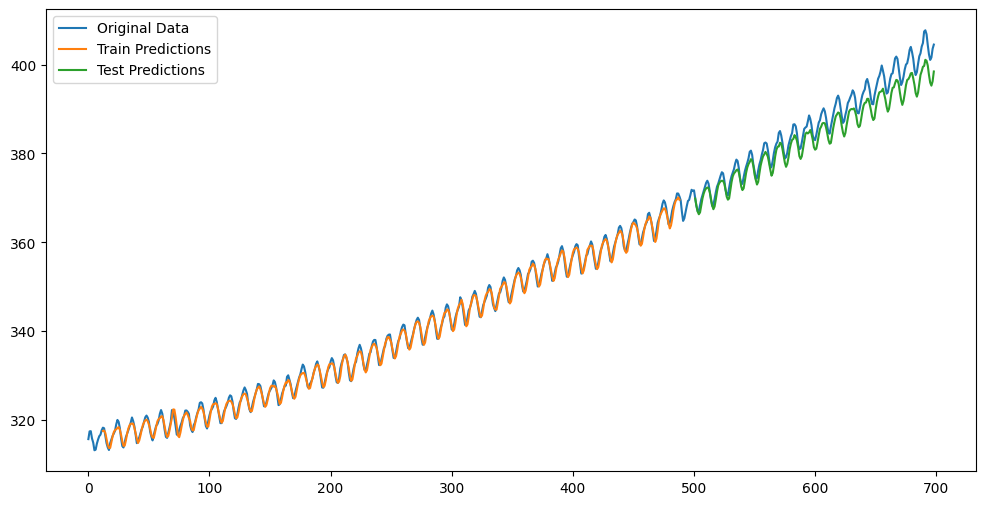

In [17]:
plot_results(original_data, x_pred_train, x_pred_test, seq_length)